## Setup and Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Load Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Project/1. Forecast/household_power_consumption.csv")

## Initial Data Preprocessing

In [ ]:
df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df = df.set_index("timestamp")
df = df.sort_index()

/tmp/ipython-input-2797048051.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"])


In [ ]:
numeric_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

Hourly series shape: (17477,)


/tmp/ipython-input-1775646764.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df["Global_active_power"].resample("H").mean()


## Resample to Hourly Data

In [ ]:
df_hourly = df["Global_active_power"].resample("H").mean()

# ---- Handle missing hours ----
df_hourly = df_hourly.interpolate()

print("Hourly series shape:", df_hourly.shape)

## Train-Test Split

In [ ]:
train_size = int(len(df_hourly) * 0.8)
train = df_hourly.iloc[:train_size]
test  = df_hourly.iloc[train_size:]

print("Train points:", len(train))
print("Test points:", len(test))

Train points: 13981
Test points: 3496


## Forecasting Functions

In [ ]:
def evaluate_forecast(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = (abs((y_true - y_pred) / y_true).mean()) * 100
    return mae, rmse, mape

## Moving Average Model Evaluation

In [ ]:
def moving_average_forecast(train_series, test_series, window):

    history = list(train_series.values)
    preds = []

    for t in range(len(test_series)):

        if len(history) < window:
            preds.append(np.mean(history))      # fallback initially
        else:
            preds.append(np.mean(history[-window:]))

        history.append(test_series.iloc[t])     # walk-forward update

    return pd.Series(preds, index=test_series.index)

In [ ]:
windows = [3, 6, 12, 24]
ma_predictions = {}
results = []

for w in windows:
    pred = moving_average_forecast(train, test, window=w)
    ma_predictions[w] = pred

    mae, rmse, mape = evaluate_forecast(test, pred)
    results.append([f"Moving Average ({w}h)", mae, rmse, mape])

## Prediction Comparison and Summary

In [ ]:
ma_results_df = pd.DataFrame(results,
                             columns=["Model","MAE","RMSE","MAPE"])

print("\nMoving Average Model Results (Hourly)")
print(ma_results_df.round(4))


Moving Average Model Results (Hourly)
                  Model     MAE    RMSE     MAPE
0   Moving Average (3h)  0.4752  0.7414  59.9789
1   Moving Average (6h)  0.5748  0.8341  83.1101
2  Moving Average (12h)  0.5627  0.7984  86.2114
3  Moving Average (24h)  0.5559  0.7827  85.7468


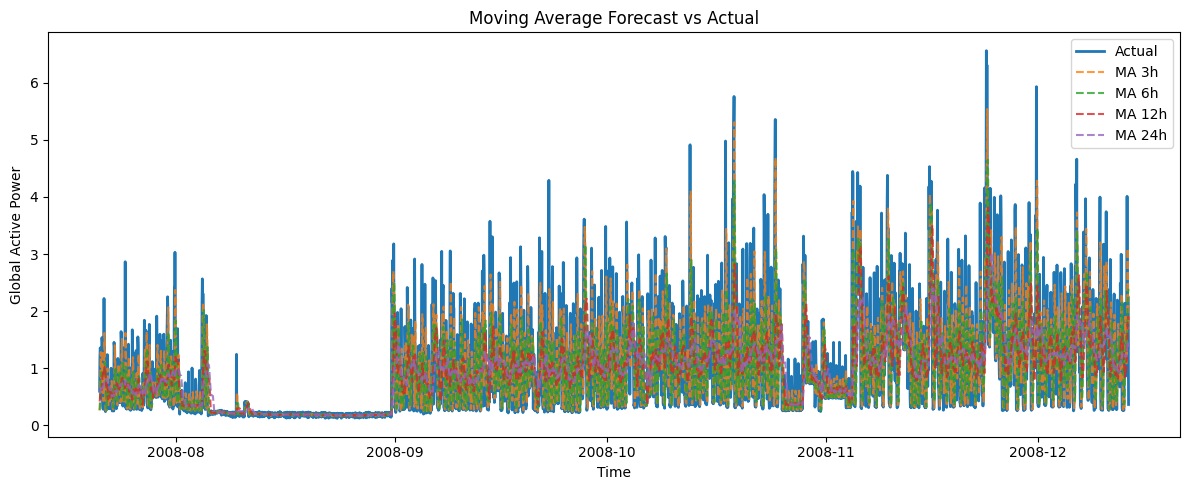

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test, label="Actual", linewidth=2)

for w, pred in ma_predictions.items():
    plt.plot(pred, label=f"MA {w}h", linestyle="--", alpha=0.8)

plt.title("Moving Average Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.tight_layout()
plt.show()

## Predict Next Hour's Consumption

In [ ]:
# --- Identify Best Moving Average Window (Lowest RMSE) ---
best_row = ma_results_df.sort_values("RMSE").iloc[0]
best_w = int(best_row["Model"].split("(")[1].replace("h)",""))

print("Best window selected:", best_w, "hours")

# --- Compute Next Timestamp ---
last_timestamp = df_hourly.index[-1]
next_timestamp = last_timestamp + pd.Timedelta(hours=1)

print("Last data timestamp :", last_timestamp)
print("Next hour to predict:", next_timestamp)

# --- Predict Next Hour Using Best Moving Average ---
history = list(df_hourly.values)

next_hour_prediction = np.mean(history[-best_w:])

next_hour_prediction = float(next_hour_prediction)

print("\nPredicted Global_active_power for next hour:")
print(f"{next_timestamp}  -->  {next_hour_prediction:.4f}")

Best window selected: 3 hours
Last data timestamp : 2008-12-13 21:00:00
Next hour to predict: 2008-12-13 22:00:00

Predicted Global_active_power for next hour:
2008-12-13 22:00:00  -->  1.3661


In [ ]:
naive_next_hour = df_hourly.iloc[-1]

print("\nNaive baseline prediction (last observed value):")
print(f"{next_timestamp}  -->  {naive_next_hour:.4f}")


Naive baseline prediction (last observed value):
2008-12-13 22:00:00  -->  0.3671


In [ ]:
# --- Select best MA window based on RMSE ---
best_row = ma_results_df.sort_values("RMSE").iloc[0]
best_w = int(best_row["Model"].split("(")[1].replace("h)",""))

print("Best Moving Average window:", best_w, "hours")

best_ma_pred = ma_predictions[best_w]

# --- Model-2 results dataframe ---
ma_model_results = pd.DataFrame({
    "Actual": test,
    f"MA_{best_w}h_Prediction": best_ma_pred
})

ma_model_results.head()

Best Moving Average window: 3 hours


,Actual,MA_3h_Prediction
timestamp,,
2008-07-21 06:00:00,0.601167,0.263511
2008-07-21 07:00:00,1.161033,0.383911
2008-07-21 08:00:00,1.356633,0.689478
2008-07-21 09:00:00,1.332733,1.039611
2008-07-21 10:00:00,0.669400,1.283467


In [ ]:
ma_compare_df = pd.DataFrame({"Actual": test})

for w, pred in ma_predictions.items():
    ma_compare_df[f"MA_{w}h_Prediction"] = pred

ma_compare_df.head()

,Actual,MA_3h_Prediction,MA_6h_Prediction,MA_12h_Prediction,MA_24h_Prediction
timestamp,,,,,
2008-07-21 06:00:00,0.601167,0.263511,0.266244,0.418239,0.558311
2008-07-21 07:00:00,1.161033,0.383911,0.328783,0.446708,0.574067
2008-07-21 08:00:00,1.356633,0.689478,0.476789,0.514722,0.610317
2008-07-21 09:00:00,1.332733,1.039611,0.651561,0.578303,0.611557
2008-07-21 10:00:00,0.669400,1.283467,0.833689,0.582289,0.652882
